In [1]:
# we create a function to oobfuscate the store names and introduce impurities for the sake of this excercise
# Scrapped or OCR results could be much more random and unpredictable.
import string
import random 
import numpy as np 
import pandas as pd

# Using seen dictionary to generate all unique values
# Main goal here is to ensure there is no cross category contamination
# 1 input has single label, that model does not get confused
seen = {}

def gen_impurities(n,word):
    for i in range(n):
        index = random.randint(0,len(word)-1)
        #print(f"impute index - {index}")

        if index%2 == 0:
            symbol = random.choice(string.punctuation)
            #print(f"Symbol = {symbol}")
            word = word[:index] + symbol + word[index:]

        if index%7 == 0:
            num = random.choice(string.digits)
            #print(f"Number = {num}")
            word = word[:index] + str(num) + word[index:]

        if index%3 == 0:
            word.replace(word[index],"")
    return word

def obfuscate(word):
    n = int(len(word)*0.5)
#     print(n)
    iteration = random.randint(1,n)
#     print(iteration)
    label = word
    for i in range(5):
        imputed_word = gen_impurities(iteration,label)
#         print(imputed_word)
        if imputed_word not in seen:
            seen[imputed_word] = 1
            return imputed_word
        seen[imputed_word] = seen[imputed_word]+1
    return word
            

def gen_gibberish(min_l,max_l):
    # initializing size of string
    l = random.randint(min_l,max_l)
    # using random.choices()
    # generating random strings
    res = ''.join(random.choices(string.ascii_uppercase +
                                 string.punctuation +
                                 string.digits, k=l))
    while res not in seen:    
        seen[res] = 1
        return res
    seen[res] = seen[res]+1
    

In [2]:
# Lets take top 100 US retailers arbitarily chosen based on their annual reported Sales

def read_data():
    df = pd.read_csv("stores.csv")
    del df['empty']
    df = df.set_index('no')
    df.head()
    return df


In [3]:
# this function will muddle up the stores to simulate real world data capture where system might introduce impurites
# the function will generate n number of instances for muddled data

# n indicates number of obfuscated records
# instance_count is the number of observation per class

def get_obfuscated_stores(stores,n):
    obfuscate_stores = stores * n
    obfuscate_stores.sort()
    df_obfuscated = pd.DataFrame({"stores": obfuscate_stores})
    df_obfuscated['bad_names'] = df_obfuscated["stores"].apply(lambda x: obfuscate(x) )
    return df_obfuscated
    
def get_catch_gibberish(instance_count,min_l,max_l):
    others = ['Other'] * instance_count
    df_other = pd.DataFrame({'stores':others})
    df_other['bad_names'] = df_other['stores'].apply(lambda x : gen_gibberish(min_l,max_l)) 
    return df_other

# the training set will also have good captures where store name was interpreted correctly
# for this purpose the we are creagin 10% bad captures

def get_good_names(stores,n):
    good_captures = stores*  n
    df_good_captures = pd.DataFrame({'stores':good_captures})
    df_good_captures['bad_names'] = df_good_captures["stores"]
    return df_good_captures

def get_data(impute_n,instance,min_l,max_l): 
    n = impute_n
    instance_count = instance
    min_l = min_l
    max_l = max_l

    df_obfuscated = get_obfuscated_stores(stores,n)
    df_other = get_catch_gibberish(instance_count,min_l,max_l)
    df_good_captures = repeat_good_names(stores,n,instance_count)
    df = pd.concat([df_obfuscated,df_good_captures,df_other])
    return df


In [4]:
# this function will muddle up the stores to simulate real world data capture where system might introduce impurites
# the function will generate n number of instances for jumbled data

# n indicates number of obfuscated records
# instance_count is the number of observation per class

def get_obfuscated_stores(stores,n):
    """
        This functions takes the stores list
        Repeats it n times
        calls teh obfuscate function to generate dirty names
    """
    obfuscate_stores = stores * n
    obfuscate_stores.sort()
    df_obfuscated = pd.DataFrame({"stores": obfuscate_stores})
    df_obfuscated['bad_names'] = df_obfuscated["stores"].apply(lambda x: obfuscate(x) )
    return df_obfuscated
    
def get_catch_gibberish(instance_count,min_l,max_l):
    others = ['Other'] * instance_count
    df_other = pd.DataFrame({'stores':others})
    df_other['bad_names'] = df_other['stores'].apply(lambda x : gen_gibberish(min_l,max_l)) 
    return df_other

# the training set will also have good captures where store name was interpreted correctly
# for this purpose the we are creagin 10% bad captures

def get_good_names(stores,n):
    good_captures = stores*  n
    df_good_captures = pd.DataFrame({'stores':good_captures})
    df_good_captures['bad_names'] = df_good_captures["stores"]
    return df_good_captures

def get_data(impute_n,instance,min_l,max_l): 
    n = impute_n
    instance_count = instance
    min_l = min_l
    max_l = max_l

    df_obfuscated = get_obfuscated_stores(stores,n)
    df_other = get_catch_gibberish(instance_count,min_l,max_l)
    df_good_captures = repeat_good_names(stores,n,instance_count)
    df = pd.concat([df_obfuscated,df_good_captures,df_other])
    return df


In [5]:
def get_train_test_data(split_ratio,impute_ratio,instance,min_l,max_l):
    test_size = (instance*split_ratio)
    train_size = (instance*(1-split_ratio))
    print(f"test_size = {test_size} & train_size = {train_size} & split = {split_ratio}")
    test_impute_n = int(test_size*impute_ratio)
    test_good_n = int(test_size - test_impute_n)
    print(f"test impute = {test_impute_n} & instances = {test_good_n}")
    df = read_data()
    stores = list(df["store"])
    # get imputed
    df_obfuscated = get_obfuscated_stores(stores,test_impute_n)
    # get good names
    df_good_names = get_good_names(stores, test_good_n)
    # get others 
    df_other = get_catch_gibberish(test_impute_n+test_good_n,min_l,max_l)
    df_test = pd.concat([df_obfuscated,df_good_names,df_other])
    
    del df_obfuscated,df_good_names,df_other
    train_impute_n = int(train_size*impute_ratio)
    train_good_n = int(train_size - train_impute_n)
    # get imputed
    df_obfuscated = get_obfuscated_stores(stores,train_impute_n)
    # get good names
    df_good_names = get_good_names(stores, train_good_n)
    # get others 
    df_other = get_catch_gibberish(train_impute_n+train_good_n,min_l,max_l)
    
    df_train = pd.concat([df_obfuscated,df_good_names,df_other])
    
    del df_obfuscated,df_good_names,df_other
    return df_train, df_test
    
    

In [6]:
df_train, df_test = get_train_test_data(0.2,0.5,10000,5,20)

test_size = 2000.0 & train_size = 8000.0 & split = 0.2
test impute = 1000 & instances = 1000


In [147]:
t = df_train.groupby('bad_names').count()

In [152]:
t.reset_index(inplace=True)
t = t.rename(columns = {'index':'bad_names'})


In [155]:
t[t['stores'] >1]

,bad_names,stores
86087,7-Eleven,4943
117765,AT&T Wireless,4643
120951,AVB Brandsource,4424
123879,Academy Sports,4505
125529,Ace Hardware,4638
...,...,...
323716,Wayfair,5346
326851,Wegmans Food Market,4311
328183,Weis Markets,4600
331787,Williams-Sonoma,4389


In [7]:
print(f"len test stores = {len(set(df_test['stores']))}")
print(f"len train stores = {len(set(df_train['stores']))}")

len test stores = 101
len train stores = 101


In [8]:
#from sklearn.model_selection import train_test_split
def get_train_test_split(df_train,df_test,one_hot_encode_labels=False):
    X_train = df_train["bad_names"].values
    y_train = df_train["stores"].values
    X_test  = df_test["bad_names"].values
    y_test  = df_test["stores"].values
    
    if one_hot_encode_labels:
        df_labels = pd.concat([df_train['stores'],df_test['stores']])
        print(f"Labels = {df_labels.shape})")
        lables = pd.get_dummies(df_labels)
        lookup = list(lables.columns)
        print(len(lookup))
        del df_labels
        y_test_labels = pd.get_dummies(y_test)
        y_test_encoded = y_test_labels.astype('float32').values
        y_train_labels = pd.get_dummies(y_train)
        y_train_encoded = y_train_labels.astype('float32').values
        return X_train,y_train_encoded,X_test,y_test_encoded, lookup
    else:
        return X_train, y_train, X_test, y_test, None
    

In [9]:

X_train, y_train, X_test, y_test, lable_lookup = get_train_test_split(df_train,
                                                                      df_test,
                                                                      one_hot_encode_labels=False)


In [10]:
print(f"Shape of X train - {X_train.shape}")
print(f"Shape of y train - {y_train.shape}")
print(f"shape of X test - {X_test.shape}")
print(f"shape of y test {y_test.shape}")
print(f"Test labels y train - {len(set(y_train))}")
print(f"Test labels X train - {len(set(X_train))}")
print(f"Test labels y test - {len(set(y_test))}")
print(f"Test labels X test - {len(set(X_test))}")

Shape of X train - (808000,)
Shape of y train - (808000,)
shape of X test - (202000,)
shape of y test (202000,)
Test labels y train - 101
Test labels X train - 335118
Test labels y test - 101
Test labels X test - 94379


In [11]:
LABELS = list(set(y_train))
print(LABELS)

def labels_to_index(label,labels=LABELS):
    return labels.index(label)

def index_to_labels(idx,labels=LABELS):
    return labels[idx]

def index_to_labels_arr(arr,labels=LABELS):
    return labels[np.argmax(arr)]

['PetSmart', 'Academy Sports', 'Sprouts Farmers Market', 'Bed Bath & Beyond', 'Walmart', 'Michaels Stores', 'J.C. Penney Company', 'Signet Jewelers', 'The Kroger Co.', 'CVS Health Corporation', 'Urban Outfitters', 'Harbor Freight Tools', 'My Demoulas', 'Advance Auto', 'Hy Vee', 'Qurate Retail', 'TJX Companies', 'Hobby Lobby Stores', 'Weis Markets', 'Bath & Body Works', 'Defense Commissary Agency', 'RH', "BJ's Wholesale Club", 'Bass Pro', 'Giant Eagle', 'Albertsons Companies', 'Golub', 'Williams-Sonoma', "Dillard's", 'Aldi', 'Wakefern / ShopRite', "Dick's Sporting Goods", 'AutoZone', "Hudson's Bay", 'Office Depot', 'Ikea North America Services', 'Barnes & Noble', 'Wayfair', 'Target', 'Good Neighbor Pharmacy', 'WinCo Foods', 'Publix Super Markets', 'Tapestry', 'Exxon Mobil Corporation', 'Meijer', 'Menards', 'AT&T Wireless', 'Wegmans Food Market', 'Ingles', 'Alimentation Couche-Tard', 'Petco', 'Ross Stores', 'Burlington', 'Other', "Lowe's Companies", 'American Eagle Outfitters', 'Total Wi

In [12]:
## Create indexed classes
y_train_tx = [labels_to_index(y) for y in y_train]
y_test_tx = [labels_to_index(y) for y in y_test]

In [13]:
print(f" y train indexed class - {y_train_tx[0]}")
print(f" y train label {y_train[0]}")
print(f" y test indexed class - {y_test[0]}")
print(f" y test indexed class - {y_test_tx[0]}")

 y train indexed class - 64
 y train label 7-Eleven
 y test indexed class - 7-Eleven
 y test indexed class - 64


In [14]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

In [16]:
import re
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [17]:
max_features = 100
sequence_length = 50

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    split = 'character',
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [18]:
train_text = raw_train.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

2023-05-25 08:36:43.167322: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [19]:
vectorize_layer.get_vocabulary()

['',
 '[UNK]',
 'e',
 ' ',
 'a',
 'o',
 's',
 'r',
 't',
 'l',
 'i',
 'n',
 'c',
 'm',
 'h',
 'd',
 'b',
 'p',
 'g',
 'u',
 'y',
 'w',
 'f',
 'v',
 'k',
 'j',
 'x',
 '7',
 'z',
 '3',
 '8',
 '2',
 '0',
 '1',
 '6',
 '9',
 '4',
 '5',
 'q',
 '’']

In [117]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text)[0], label

In [21]:
print("3 ---> ",vectorize_layer.get_vocabulary()[3])
print(" 30 ---> ",vectorize_layer.get_vocabulary()[30])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))


3 --->   
 30 --->  8
Vocabulary size: 40


In [34]:
size = len(y_train_tx)

In [89]:
train_idx = int(size*0.8)
val_idx = int(size*0.2)
print(f"train size - {train_idx} val size - {val_idx}")

X_traning_ds = X_train[0:train_idx]
y_train_ds = y_train_tx[0:train_idx]
X_val_ds = X_train[train_idx:train_idx+val_idx]
y_val_ds = y_train_tx[train_idx:train_idx+val_idx]

train size - 646400 val size - 161600


In [92]:
print(f"Training - {X_traning_ds.shape} Val - {X_val_ds.shape}")
print(f"Training - {len(y_train_ds)} Val - {len(y_val_ds)}")

Training - (646400,) Val - (161600,)
Training - 646400 Val - 161600


In [93]:

raw_train = tf.data.Dataset.from_tensor_slices((X_traning_ds, y_train_ds))
raw_val = tf.data.Dataset.from_tensor_slices((X_val_ds, y_val_ds))
raw_test = tf.data.Dataset.from_tensor_slices((X_test, y_test_tx))


In [125]:
train_ds = raw_train.map(vectorize_text)
val_ds = raw_val.map(vectorize_text)
test_ds = raw_test.map(vectorize_text)

In [109]:
text_batch, label_batch = next(iter(train_ds))
print(text_batch)
print(label_batch)

tf.Tensor(
[[27  2  9  2 23  2 30 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]], shape=(1, 50), dtype=int64)
tf.Tensor(64, shape=(), dtype=int32)


In [132]:
BUFFER_SIZE = 1000
BATCH_SIZE = 128


fin_train_ds = train_ds.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BATCH_SIZE,drop_remainder=True)
fin_val_ds = val_ds.batch(batch_size=BATCH_SIZE,drop_remainder=True)
fin_test_ds = test_ds.batch(batch_size=BATCH_SIZE,drop_remainder=True)

In [133]:
text_batch, label_batch = next(iter(fin_train_ds))
print(text_batch)
print(label_batch)
    

tf.Tensor(
[[32 27  2 ...  0  0  0]
 [27  2  9 ...  0  0  0]
 [32 27  2 ...  0  0  0]
 ...
 [30 27  2 ...  0  0  0]
 [27  2  9 ...  0  0  0]
 [27  2  9 ...  0  0  0]], shape=(128, 50), dtype=int64)
tf.Tensor(
[64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64], shape=(128,), dtype=int32)


In [138]:
embedding_dim = 16


def get_model(embedding_dim,max_features):
    model = tf.keras.Sequential([
          layers.Embedding(max_features + 1, embedding_dim),
          layers.Bidirectional(layers.LSTM(128)),
          layers.Dropout(0.2),
          layers.Dense(128,activation='tanh', kernel_regularizer='l2'),
          layers.Dropout(0.2),
          layers.Dense(101, activation='softmax')])
    model.summary()
    return model

In [139]:
model = get_model(embedding_dim,max_features)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 16)          1616      
                                                                 
 bidirectional_6 (Bidirectio  (None, 256)              148480    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 101)               13029     
                                                      

In [140]:
## The loss function and the metrics need to be compliant to get good results

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer= 'adam',
              metrics=tf.keras.metrics.SparseCategoricalAccuracy()
             )

In [141]:
epochs = 10
history = model.fit(
    fin_train_ds,
    validation_data=fin_val_ds,
    epochs=epochs)

Epoch 1/10
5050/5050 [==============================] - 191s 38ms/step - loss: 1.7296 - sparse_categorical_accuracy: 0.7328 - val_loss: 0.7028 - val_sparse_categorical_accuracy: 0.9509
Epoch 2/10
5050/5050 [==============================] - 189s 37ms/step - loss: 0.5485 - sparse_categorical_accuracy: 0.9349 - val_loss: 0.6568 - val_sparse_categorical_accuracy: 0.9509
Epoch 3/10
5050/5050 [==============================] - 186s 37ms/step - loss: 0.3551 - sparse_categorical_accuracy: 0.9655 - val_loss: 0.6813 - val_sparse_categorical_accuracy: 0.9509
Epoch 4/10
5050/5050 [==============================] - 187s 37ms/step - loss: 0.2226 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.7143 - val_sparse_categorical_accuracy: 0.9509
Epoch 5/10
5050/5050 [==============================] - 186s 37ms/step - loss: 0.1928 - sparse_categorical_accuracy: 0.9850 - val_loss: 0.7319 - val_sparse_categorical_accuracy: 0.9509
Epoch 6/10
5050/5050 [==============================] - 186s 37ms/step - lo

In [157]:
# lets evaluate the model on the unseen test dataset
loss, accuracy = model.evaluate(fin_test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

1578/1578 [==============================] - 20s 13ms/step - loss: 0.2335 - sparse_categorical_accuracy: 0.9743
Loss:  0.23351739346981049
Accuracy:  0.97431480884552


In [158]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

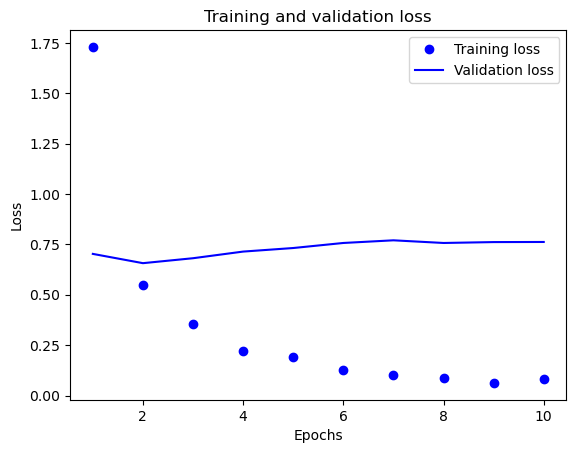

In [160]:
import matplotlib.pyplot as plt

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


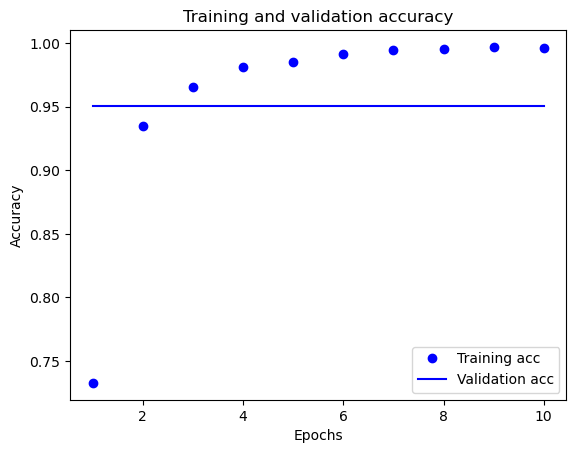

In [161]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [233]:
def _top_3_classes(logits):
    df = pd.DataFrame(
        {"logits":logits,
         "idx":[x for x in range(len(logits))]
        })
    top3 = df.sort_values(by = 'logits', ascending=False)['idx'].head(3).values
    return top3
    

def predict_new_word(word:str)-> str:
    # we will vectorize the word
    vec_word = vectorize_layer(word)
    # reshape to the shae model expects
    vec_word = vec_word.numpy().reshape(1,50)
    # call predict functions
    predicted = model.predict(vec_word)
    predicted_idx = np.argmax(predicted)
    predicted_conf = predicted[0][predicted_idx]
    predicted_label = index_to_labels(predicted_idx)
    print(f"received - {word} predicted - {predicted_label} with confidence of {predicted_conf}")
    top3 = _top_3_classes(predicted.reshape(101))
    top3_labels = []
    for i in top3:
        top3_labels.append(index_to_labels(i))
    print(f"The top 3 are - {top3_labels} - {top3}")
    return predicted_label,predicted 


In [234]:
predict_new_word('7a G3 7')

1/1 [==============================] - 0s 51ms/step
received - 7a G3 7 predicted - Aldi with confidence of 0.3645141124725342
The top 3 are - ['Aldi', 'Gap', 'Hy Vee'] - [29 75 14]


('Aldi',
 array([[7.57307222e-04, 2.16645440e-05, 4.71109757e-03, 7.25210043e-07,
         2.30606794e-02, 1.20367086e-03, 7.17962621e-06, 9.80963450e-05,
         3.33030679e-04, 8.79876970e-05, 1.54696113e-06, 3.83287971e-03,
         4.82999212e-06, 1.52741904e-05, 1.58086464e-01, 3.59356477e-07,
         4.43499374e-07, 9.18046790e-05, 2.76669562e-05, 7.83645373e-05,
         5.42997615e-04, 1.29792723e-03, 5.13234991e-04, 8.27359688e-03,
         3.62932115e-05, 1.98609126e-03, 9.95933195e-04, 9.27112342e-05,
         2.47205375e-04, 3.64514112e-01, 1.81550859e-04, 2.06978337e-04,
         6.97483309e-04, 5.83010296e-05, 2.65220223e-07, 1.75009758e-04,
         2.85768579e-06, 3.71873155e-02, 1.31593726e-03, 1.73121574e-04,
         3.72105660e-06, 3.59302363e-03, 1.43397308e-04, 1.66135601e-06,
         1.56783627e-03, 1.06089830e-03, 8.30752106e-06, 6.73441624e-04,
         3.96865010e-02, 3.87525361e-05, 1.23350909e-02, 1.47566418e-04,
         5.22788723e-05, 1.38733967e-07, 9

In [238]:
predict_new_word('12321ueiajsidams')

1/1 [==============================] - 0s 37ms/step
received - 12321ueiajsidams predicted - Sherwin-Williams with confidence of 0.3320485055446625
The top 3 are - ['Sherwin-Williams', 'True Value Co.', 'Meijer'] - [68 72 44]


('Sherwin-Williams',
 array([[1.23207197e-02, 4.04282298e-04, 2.44811468e-04, 1.07689742e-02,
         6.02326218e-05, 2.84135807e-04, 3.98325879e-04, 5.33507155e-05,
         1.21520745e-04, 1.91351774e-05, 5.76398452e-04, 2.51227786e-04,
         3.28992680e-03, 1.06370871e-05, 4.82703699e-03, 4.93574131e-04,
         3.74947488e-02, 4.28572716e-03, 9.57593601e-03, 5.85023127e-03,
         9.37829353e-03, 3.25849764e-02, 3.15083074e-03, 2.48321355e-03,
         3.90921836e-04, 1.71031585e-04, 5.97190857e-02, 1.40990363e-03,
         5.27443226e-05, 2.11836174e-04, 1.34025631e-03, 1.67408885e-04,
         5.84874069e-03, 1.88241098e-02, 1.15132029e-03, 2.61955807e-04,
         1.07878027e-03, 6.93392794e-05, 5.88602480e-03, 5.88474737e-04,
         1.58651219e-05, 4.82834410e-04, 7.28900122e-05, 6.98344142e-04,
         9.26519707e-02, 4.95676541e-05, 8.96262645e-04, 6.85772533e-03,
         8.90888696e-05, 9.81162520e-06, 5.02101611e-04, 2.07813317e-03,
         2.92433752e-03, 1.420

In [239]:
predict_new_word('Target')

1/1 [==============================] - 0s 20ms/step
received - Target predicted - Target with confidence of 0.9963459372520447
The top 3 are - ['Target', 'Rite Aid', 'RH'] - [38 88 21]


('Target',
 array([[6.88417545e-09, 9.40300779e-08, 3.32356032e-09, 1.65745533e-07,
         3.46848665e-08, 6.04054862e-10, 3.53611455e-07, 1.40517307e-06,
         2.49750941e-04, 4.40291430e-08, 2.47462413e-06, 2.31964165e-07,
         1.75462571e-06, 8.84587514e-09, 6.90336310e-05, 2.98634927e-06,
         1.14801605e-06, 1.63478518e-07, 3.13501114e-09, 6.67684560e-07,
         3.69117311e-06, 5.27523749e-04, 1.34872580e-05, 5.63650531e-07,
         3.02246667e-06, 5.67530662e-07, 3.99832206e-04, 2.25158786e-07,
         4.99256370e-09, 6.28723283e-05, 6.70552538e-08, 5.56639124e-10,
         3.55242752e-04, 1.57714430e-06, 8.03626608e-06, 2.68138063e-08,
         5.05341859e-07, 4.56412236e-05, 9.96345937e-01, 2.52345126e-06,
         2.24511514e-05, 9.62675949e-06, 1.12320104e-05, 2.46675264e-10,
         2.97295155e-05, 1.41496196e-06, 2.72005991e-08, 7.04233543e-08,
         1.01041849e-04, 3.63419045e-10, 3.43663487e-05, 4.33220384e-06,
         1.23953854e-04, 1.53795809e-09,

In [240]:
predict_new_word('T1argea214')

1/1 [==============================] - 0s 25ms/step
received - T1argea214 predicted - Target with confidence of 0.41621917486190796
The top 3 are - ['Target', 'Rite Aid', 'Tapestry'] - [38 88 42]


('Target',
 array([[9.64767241e-06, 4.79727078e-06, 9.45248246e-07, 1.42754521e-04,
         2.98799732e-05, 1.71112532e-07, 4.41638877e-05, 2.85803253e-04,
         2.77272817e-02, 4.68058079e-06, 5.18164504e-03, 3.24491411e-04,
         1.13839051e-04, 5.82534012e-05, 1.03439488e-04, 2.33493885e-03,
         2.18229904e-03, 7.13528207e-05, 6.99040975e-05, 3.96585732e-04,
         9.53110703e-06, 1.40076748e-03, 5.48507378e-04, 4.97600879e-04,
         1.89368124e-03, 2.45445008e-05, 6.18101563e-04, 3.30003604e-05,
         9.09602968e-05, 7.28232990e-05, 5.18411935e-06, 1.40671858e-07,
         4.72877175e-04, 6.58453209e-04, 1.12658367e-02, 5.09837582e-06,
         3.22629837e-03, 1.53873069e-02, 4.16219175e-01, 5.23982199e-05,
         2.40449514e-02, 2.59085529e-04, 4.99654971e-02, 1.20573736e-06,
         1.33658829e-03, 1.82019523e-03, 2.82585752e-05, 2.34600907e-06,
         2.28579878e-03, 1.26634018e-06, 2.29755286e-04, 6.59380713e-03,
         3.71060381e-03, 2.73456322e-07,

In [241]:
label, logits = predict_new_word('T1argea214')

1/1 [==============================] - 0s 47ms/step
received - T1argea214 predicted - Target with confidence of 0.41621917486190796
The top 3 are - ['Target', 'Rite Aid', 'Tapestry'] - [38 88 42]
